### Comparative Study of Conventional Machine Learning and Deep Learning Models in MRI Image-based Brain Tumor Detection

### Research Questions

1. What are the differences between conventional machine learning models and convolutional neural networks (CNNs) and transfer learning models while detecting brain tumors using MRI images?
2. Would enhanced Transfer Learning enhance perfomance when compaired to traditional and raw cnn models?
3. To what extent do the models match real labels, as indicated by kappa score and other metrics of evaluation?

### Working Approach
For the development of the project, My main goal will be to compaire the performance of various machine learning models under this reseach in detecting brain tumors from MRI images. The model categrories to be compaired will be:

- Traditional models i.e  Logistic Regression (linear model) and Decision Tree (non-linear tree based model)
- Deep learning like
    - Handcrafted Convolutional Neural Network (CNN)
    - Pre-trained transfer learning models
        - VGG16
        - ResNet50

I will perfom image processing like scaling, transfoming, histogram equalization etc with the main goal being to  improve feature visibility and classification efficiency. All models will be tested for accuracy, F1-score, and Cohen's kappa metrics to measure prediction agreement with true ground truth labels. The  work aims to find out which methodology offers the best performance-reliability tradeoff, especially in clinical diagnostic scenarios.

### Data Information
- Dataset source - https://figshare.com/articles/dataset/brain_tumor_dataset/1512427
- Documentation - https://figshare.com/articles/dataset/brain_tumor_dataset/1512427?file=51340418
- Data Type - Matlab Images
- Classes - has classes like **glioma**, **meningioma** and **pituitary tumors**
- Who published the data -  The data were Authored and published by **Jun Cheng** [*dataset posted on 2024-12-21, 15:57 authored by Jun Cheng*]
- When -  First published online on **2024-12-21 , 15:57**

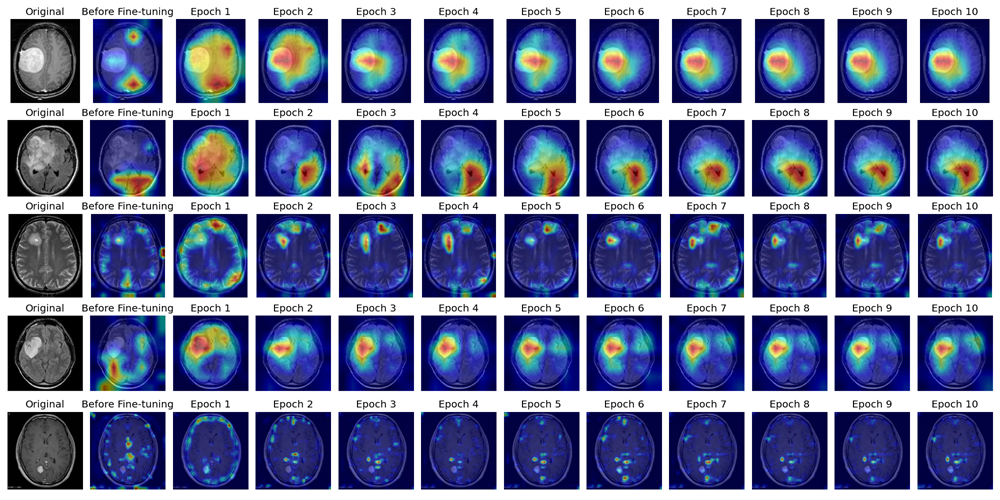

In [1]:
import os, glob, random, cv2
import zipfile
import shutil
import warnings

import pandas as pd
import numpy as np

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image, ImageFile
import seaborn as sns




# for reading mat files
from scipy.io import loadmat
from skimage.measure import regionprops, label as label_mask_ftn
import h5py
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# modelling
import torch.optim as optim
import torch.nn as nn
import torch

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader




warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
sns.set(style="whitegrid")

In [2]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# download the data from fig
!wget https://figshare.com/ndownloader/articles/1512427/versions/8

--2025-05-30 20:41:00--  https://figshare.com/ndownloader/articles/1512427/versions/8
Resolving figshare.com (figshare.com)... 52.51.14.225, 34.248.8.194, 52.49.170.217, ...
Connecting to figshare.com (figshare.com)|52.51.14.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879503381 (839M) [application/zip]
Saving to: ‘8’

8                   100%[===================>] 838.76M  27.8MB/s    in 31s     

2025-05-30 20:41:32 (26.8 MB/s) - ‘8’ saved [879503381/879503381]



In [4]:
# delete and recreate the ./process directory in order to avoid overwriting
if os.path.exists("./process"):
    shutil.rmtree("./process")
os.makedirs("./process", exist_ok=True)
print("Recreated './process' folder.")

# unzip the donloaded file into ./process
if os.path.exists("8") and zipfile.is_zipfile("8"):
    with zipfile.ZipFile("8", 'r') as zip_ref:
        zip_ref.extractall("./process")
    print("Unzipped '8' into './process'.")
else:
    print("File '8' not found or is not a ZIP file.")



Recreated './process' folder.
Unzipped '8' into './process'.


In [5]:
os.listdir("./process")

['README 2024.txt',
 'brainTumorDataPublic_767-1532.zip',
 'brainTumorDataPublic_2299-3064.zip',
 'cvind.mat',
 'brainTumorDataPublic_1533-2298.zip',
 'brainTumorDataPublic_1-766.zip']

In [6]:
!cat "./process/README 2024.txt"

In [7]:
# lets get the target zips we want
ZIP_FILE_NAMES = [
    'brainTumorDataPublic_2299-3064.zip',
    'brainTumorDataPublic_767-1532.zip',
    'brainTumorDataPublic_1533-2298.zip',
    'brainTumorDataPublic_1-766.zip'
]
ZIP_FILE_NAMES

['brainTumorDataPublic_2299-3064.zip',
 'brainTumorDataPublic_767-1532.zip',
 'brainTumorDataPublic_1533-2298.zip',
 'brainTumorDataPublic_1-766.zip']

In [8]:

# recreate ./process/mat to store unzipped mat images
mat_dir = "./process/mat"
if os.path.exists(mat_dir):
    shutil.rmtree(mat_dir)
os.makedirs(mat_dir, exist_ok=True)
print("Recreated './process/mat' folder.")

for zip_path in ZIP_FILE_NAMES:
    full_zip_path = os.path.join("./process", zip_path)
    with zipfile.ZipFile(full_zip_path, 'r') as zip_ref:
        zip_ref.extractall(mat_dir)
    print(f"Extracted {zip_path} into './process/mat'.")


Recreated './process/mat' folder.
Extracted brainTumorDataPublic_2299-3064.zip into './process/mat'.
Extracted brainTumorDataPublic_767-1532.zip into './process/mat'.
Extracted brainTumorDataPublic_1533-2298.zip into './process/mat'.
Extracted brainTumorDataPublic_1-766.zip into './process/mat'.


In [9]:
# lets get the file extracted and know they are how many
mat_files = glob.glob("./process/mat/**/*.mat", recursive=True)


print(f"Total .mat iamge files in './process/mat': {len(mat_files)}")

Total .mat iamge files in './process/mat': 3064


In [10]:
random_file = random.choice(mat_files)

with h5py.File(random_file, 'r') as f:
    print(f"Keys in {random_file}:")
    print(list(f.keys()))

    #data
    cjdata = f['cjdata']

    label_data = cjdata['label']
    label = int(label_data[()][0][0])
    print("label is", label)

    image_data = cjdata['image']
    image_np = image_data[()] 

    print("image shape is", image_np.shape)

    mask = cjdata['tumorMask'][()]

    print("Mask Shape is ", mask.shape)

Keys in ./process/mat/2270.mat:
['cjdata']
label is 2
image shape is (512, 512)
Mask Shape is  (512, 512)


In [11]:
#  a function to process the files
# The processing is an extract from the readme file above
def process_mat_files(input_path, output_path="./processed_data"):
    """
    convert .mat files to image and mask files, and returns a df 
    with columns: ['image_path', 'mask_path', 'label']
    """
    os.makedirs(output_path, exist_ok=True)
    image_path = os.path.join(output_path, "images")
    mask_path = os.path.join(output_path, "masks")
    os.makedirs(image_path, exist_ok=True)
    os.makedirs(mask_path, exist_ok=True)

    mat_files = glob.glob(os.path.join(input_path, "*.mat"))
    records = []

    for mat_file in tqdm(mat_files, desc="Processing .mat files"):
        try:
            with h5py.File(mat_file, 'r') as f:
                cjdata = f['cjdata']

                # get the image and convert to uint8
                image = cjdata['image'][()]
                image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)

                # get the mask for tumor
                #we are doing just classification, the mask will be for visualization part
                mask = cjdata['tumorMask'][()].astype(np.uint8) * 255

                # label
                label = int(cjdata['label'][()][0][0])

                # create filenames
                base_name = os.path.splitext(os.path.basename(mat_file))[0]
                img_file_path = os.path.join(image_path, f"{base_name}.png")
                mask_file_path = os.path.join(mask_path, f"{base_name}_mask.png")

                # save them
                Image.fromarray(image).save(img_file_path)
                Image.fromarray(mask).save(mask_file_path)

                # keep record
                records.append({
                    'image_path': img_file_path,
                    'mask_path': mask_file_path,
                    'label': label
                })
        except Exception as e:
            print(f"Failed to process {mat_file}: {e}")
    df = pd.DataFrame(records)
    return df


In [12]:
df = process_mat_files(input_path="./process/mat")

Processing .mat files: 100%|██████████| 3064/3064 [02:08<00:00, 23.78it/s]


In [13]:
df.head()

,image_path,mask_path,label
0,./processed_data/images/827.png,./processed_data/masks/827_mask.png,2
1,./processed_data/images/1869.png,./processed_data/masks/1869_mask.png,2
2,./processed_data/images/1864.png,./processed_data/masks/1864_mask.png,2
3,./processed_data/images/248.png,./processed_data/masks/248_mask.png,1
4,./processed_data/images/2869.png,./processed_data/masks/2869_mask.png,2


In [14]:
# rename 1 for meningioma, 2 for glioma, 3 for pituitary tumor

label_mapping_to_name = {
    1: "meningioma",
    2: "glioma",
    3: "pituitary tumor"
}

# create a new column for label names
df["label_name"] = df["label"].map(label_mapping_to_name)
df.head()

,image_path,mask_path,label,label_name
0,./processed_data/images/827.png,./processed_data/masks/827_mask.png,2,glioma
1,./processed_data/images/1869.png,./processed_data/masks/1869_mask.png,2,glioma
2,./processed_data/images/1864.png,./processed_data/masks/1864_mask.png,2,glioma
3,./processed_data/images/248.png,./processed_data/masks/248_mask.png,1,meningioma
4,./processed_data/images/2869.png,./processed_data/masks/2869_mask.png,2,glioma


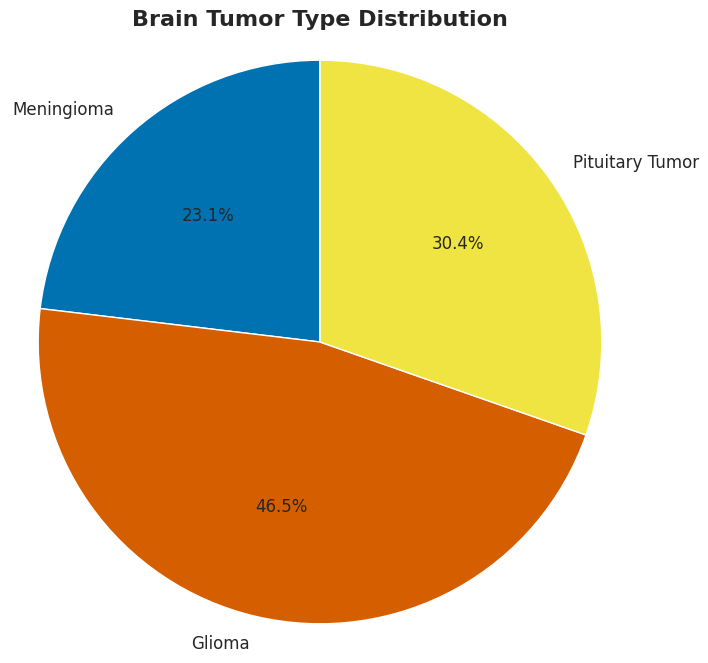

In [15]:
# lets check the distribution of labels
labels, lbl_counts = np.unique(df["label"], return_counts=True)


# the labels and also color
label_names = ['Meningioma', 'Glioma', 'Pituitary Tumor']
colors = ['#0072B2', '#D55E00', '#F0E442']

# plot piue chart
plt.figure(figsize=(8, 8))
plt.pie(lbl_counts, 
        labels=label_names, 
        colors=colors,
        autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 12})
plt.title("Brain Tumor Type Distribution", fontsize=16, weight='bold')
plt.axis('equal') 
plt.show()

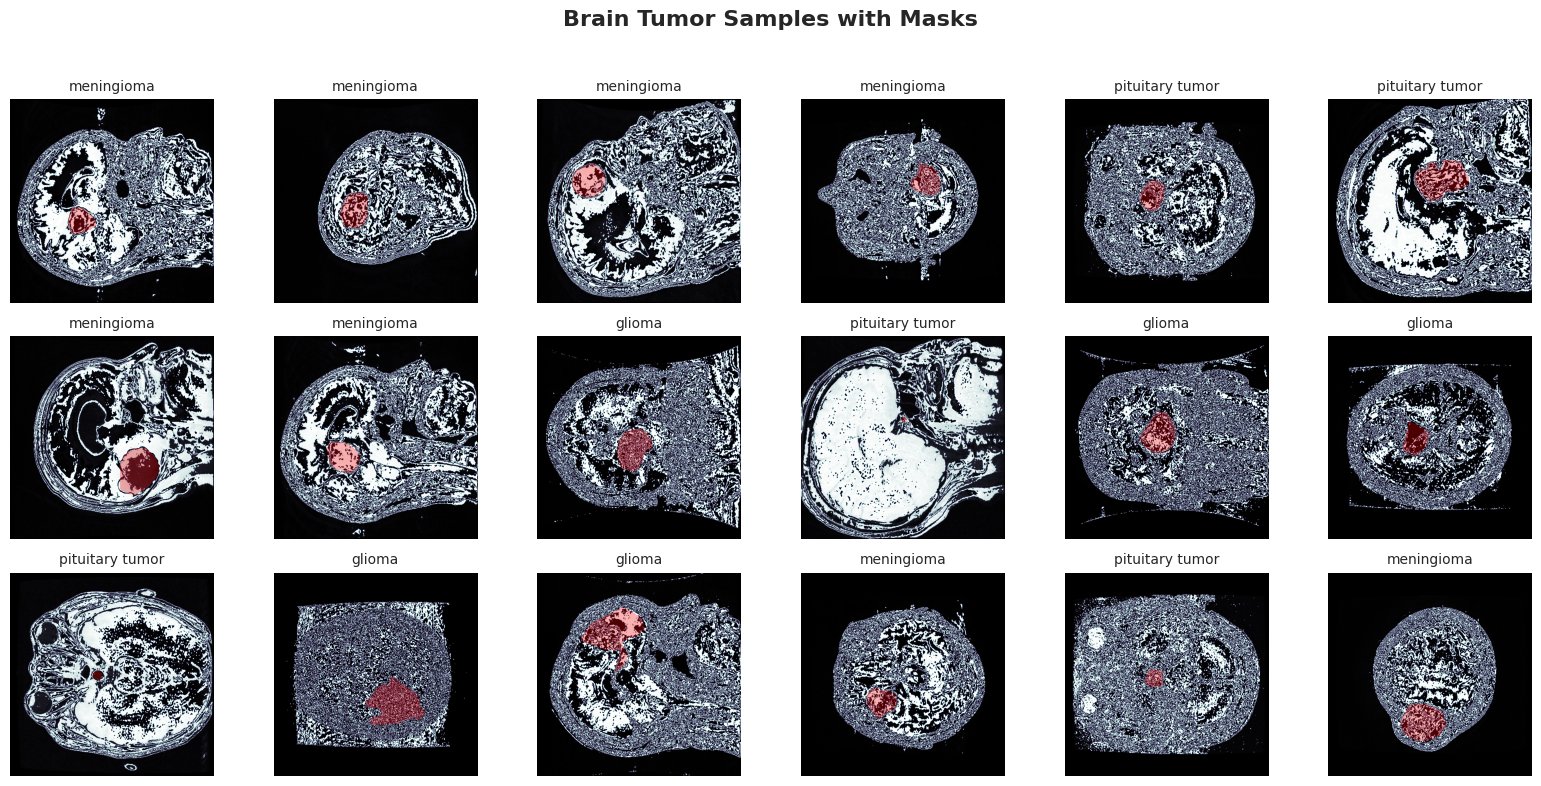

In [16]:
# sample out some random imgs
sample_df = df.sample(n=18, random_state=42).reset_index(drop=True)

plt.figure(figsize=(16, 8))
for i in range(18):
    image_path = sample_df.loc[i, 'image_path']
    mask_path = sample_df.loc[i, 'mask_path']
    label = str(sample_df.loc[i, 'label_name'])
    #read the images
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path)) > 0 #supposed to be boolena

    # do a plot
    plt.subplot(3, 6, i + 1)
    plt.imshow(image, cmap='bone')
    
    # make black in mask as transparent--Nothing
    masked = np.ma.masked_where(mask == False, mask)
    plt.imshow(masked, alpha=0.3, cmap='autumn')

    plt.title(label, fontsize=10)
    plt.axis('off')

plt.suptitle("Brain Tumor Samples with Masks", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


---
# Exploratory Analysis of Brain Tumor Images
The main goal for the anasysis is to be able to identify whether there are distinguishable characteristics that can be used to differentiate the tumors. It will main be quantifying the most relevant features in images
We are going to extract and analyze a set of morphological and intensity-based features from the tumor regions. This will help in informations like tumor size, shape, intersity, patterns etcs of the 3 tumor types we have.


## Features Extracted and Their Relevance
- Tumor Size (`tumor_size`) -  The total number of pixels that the tumor occupies in the mask. It represents tumor volumnn in 2d slice which can be used to show tumor growth and how severe it is

- Tumor Area (`tumor_area`) - It is calculated  by the region properties function, similar to tumor size, which is the area of the contiguous tumor area.

- Tumor Perimeter (`tumor_perimeter`) - The border perimeter of the tumor. It helps in accessing tumor complexity and irregularity i.e those tumor which are more irregular (on boarders) have larger perimeter.

- Eccentricity (`eccentricity`) - Measures how elongated the tumor shape is, with 0 being a perfect circle and values approaching 1 indicating more elongated shapes. Help recognize tumors based on shape.

- Solidity (`solidity`) - Ratio between the area of the tumor and the area of the convex hull of the tumor. It defines how "compact" or "filled" the tumor area is, indicating shape irregularities such as indentations or concavities.

- Aspect Ratio (`aspect_ratio`) - This is the ratio of the width to the height of the tumor bounding box. It shows shape elongation of the tumor

- Mean Intensity (`mean_intensity`) - The average pixel intensity of the tumor region. SHows how bright/contrast the tumor tissues are in the MRI slice.

- Standard Deviation of Intensity (`std_intensity`) - It shows how variable the pixel intensity within the tumor.  The higher the value, the more hetegorogenous the tumor is.

Through extraction of these features on a representative subsample of the dataset (we sample in order to get the representation of the images population as well as utilize available resouses well by using less resources for extraction), It helps provide more detailed analysis and visualization of statistical comparison that will identify characteristic patterns between tumor types. 
It is necessary to provide a foundation for later stages, including classification modeling and clinical interpretation.

---

In [17]:

tumor_stats = []

# we will just use about 1k images
SAMPLE_SIZE = 1000
sample_df = df.sample(SAMPLE_SIZE, random_state=2025)
# iterate through the images
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = np.array(Image.open(row['image_path']))
    mask = np.array(Image.open(row['mask_path'])) > 0
    if mask.sum() == 0:
        continue  # skip empty masks

    # get region properties
    labeled_mask = label_mask_ftn(mask)
    props = regionprops(labeled_mask)

    if len(props) == 0:
        continue

    #I'm assuming no image has more than 1 tumor.
    #  In this case we just analysise one tumor per image
    region = props[0]

    minr, minc, maxr, maxc = region.bbox
    width = maxc - minc
    height = maxr - minr
    aspect_ratio = width / height if height > 0 else 0


    tumor_stats.append({
        'label': row['label'],
        'label_name': row['label_name'],
        'tumor_size': mask.sum(),
        'tumor_area': region.area,
        'tumor_perimeter': region.perimeter,
        'eccentricity': region.eccentricity,
        'mean_intensity': image[mask].mean(),
        'std_intensity': image[mask].std(),
        'centroid_y': region.centroid[0],
        'centroid_x': region.centroid[1],
        'solidity': region.solidity,
        'aspect_ratio': aspect_ratio,
        
    })
stat_df = pd.DataFrame(tumor_stats)

100%|██████████| 1000/1000 [00:09<00:00, 103.61it/s]


In [18]:
stat_df.head()

,label,label_name,tumor_size,tumor_area,tumor_perimeter,eccentricity,mean_intensity,std_intensity,centroid_y,centroid_x,solidity,aspect_ratio
0,2,glioma,6971,6971.0,310.835570,0.480921,107.430354,124.338323,335.666188,253.583560,0.989215,1.149425
1,3,pituitary tumor,915,915.0,110.911688,0.496034,107.353005,119.977671,214.684153,255.965027,0.976521,1.125000
2,1,meningioma,638,638.0,95.840620,0.584270,121.595611,116.756543,306.506270,209.203762,0.953662,0.843750
3,3,pituitary tumor,1065,1065.0,128.183766,0.834420,116.165258,120.621166,251.597183,307.991549,0.977064,0.541667
4,2,glioma,21352,21352.0,879.335137,0.875298,124.257915,123.830696,228.687664,155.557372,0.707442,0.679537


In [19]:
stat_df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,1000.0,2.066000,0.729504,1.000000,2.000000,2.000000,3.000000,3.000000
tumor_size,1000.0,4378.971000,3693.278435,229.000000,1699.750000,3293.000000,5897.750000,25461.000000
tumor_area,1000.0,4378.971000,3693.278435,229.000000,1699.750000,3293.000000,5897.750000,25461.000000
tumor_perimeter,1000.0,249.690440,119.246428,54.384776,160.685552,230.030483,311.986327,1147.070201
eccentricity,1000.0,0.644203,0.168291,0.115034,0.532316,0.663702,0.771206,0.982598
mean_intensity,1000.0,114.561415,24.471580,32.877307,101.871465,112.639020,122.815381,230.953394
std_intensity,1000.0,116.991058,12.512694,21.733633,117.388884,121.468979,123.049497,126.313757
centroid_y,1000.0,256.699905,53.774985,106.538136,215.961746,252.751982,296.976672,393.530846
centroid_x,1000.0,233.280127,58.682814,84.235493,193.048354,235.013961,278.981975,394.682266
solidity,1000.0,0.944585,0.063151,0.484848,0.939973,0.967685,0.978016,0.989859


# I. Dimensionality Reduction using PCA
In this case, through the use of PCA, we are trying to check if the flattened features can vusually split the different tumor types

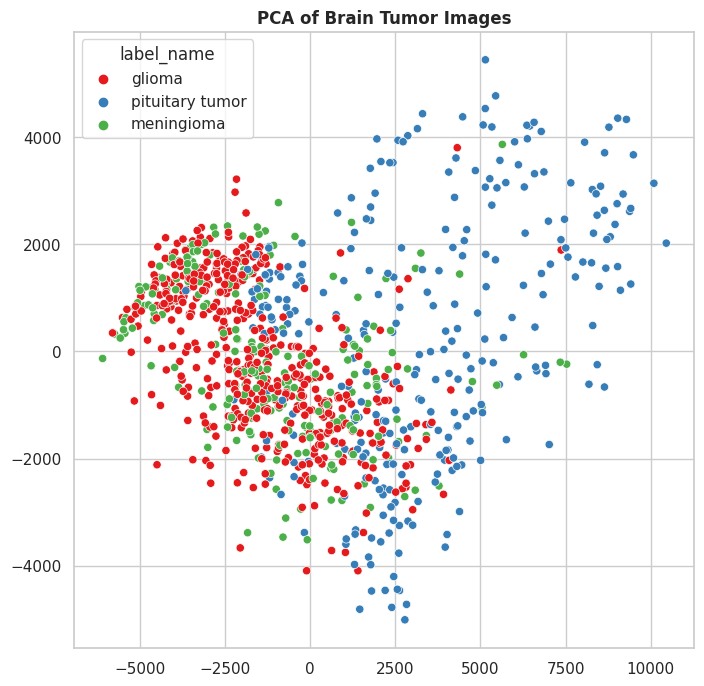

In [20]:
# get a sample data and run pca and plot
X = np.stack([np.array(Image.open(p).resize((128, 128))).flatten() for p in sample_df.image_path])
y = sample_df.label.values

# create 2d so that we can easily plot
X_pca = PCA(n_components=2).fit_transform(X)

# plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=sample_df.label_name, palette="Set1")
plt.title("PCA of Brain Tumor Images", fontweight="bold")
plt.show()


As it can be observed `pituitary tumor` seems to be very distint from the other two. It also have extreme values (this is based on principal values)

### II. Tumor Size by Class
- This helps shows which tumor appears bigger/has more pixels on average than the other

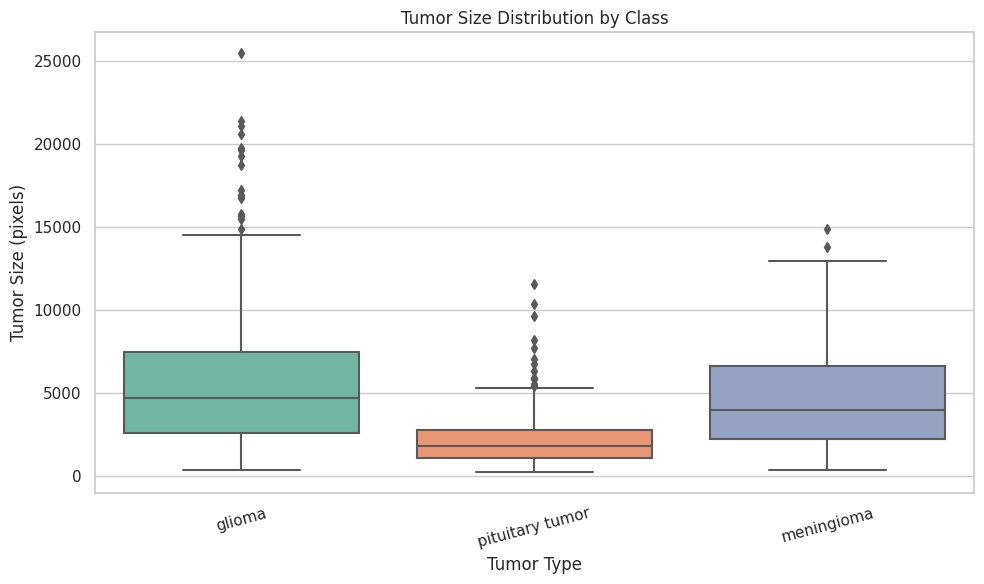

In [21]:
# plot a box plot for this
plt.figure(figsize=(10, 6))
sns.boxplot(data=stat_df, x='label_name', y='tumor_size', palette='Set2')
plt.title('Tumor Size Distribution by Class')
plt.ylabel('Tumor Size (pixels)')
plt.xlabel('Tumor Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### Mean Intensity Inside Tumor

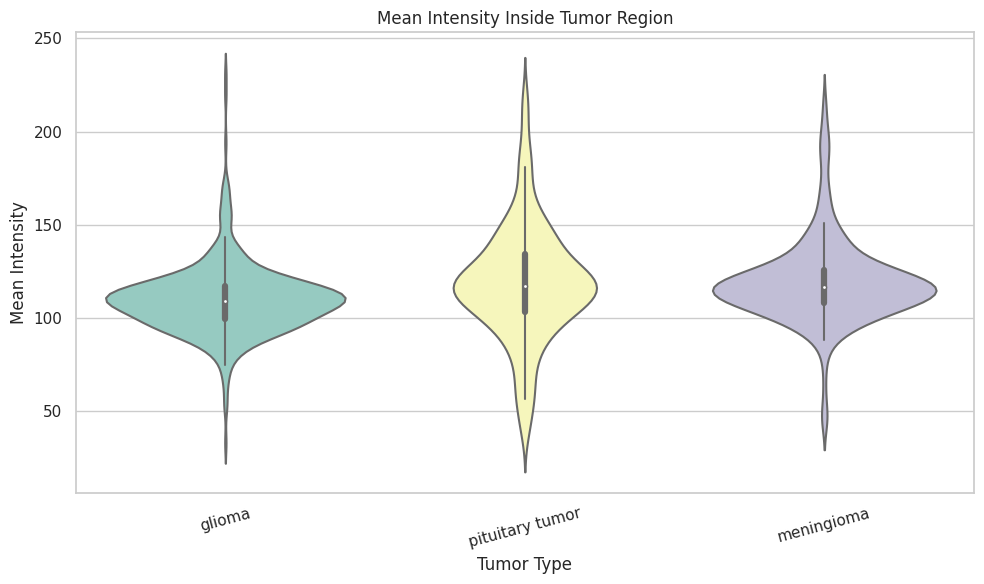

In [22]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=stat_df, x='label_name', y='mean_intensity', palette='Set3')
plt.title('Mean Intensity Inside Tumor Region')
plt.ylabel('Mean Intensity')
plt.xlabel('Tumor Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### III.  Tumor Eccentricity Comparison
- shows how elongated the tumor is (0 = circle, 1 = line)

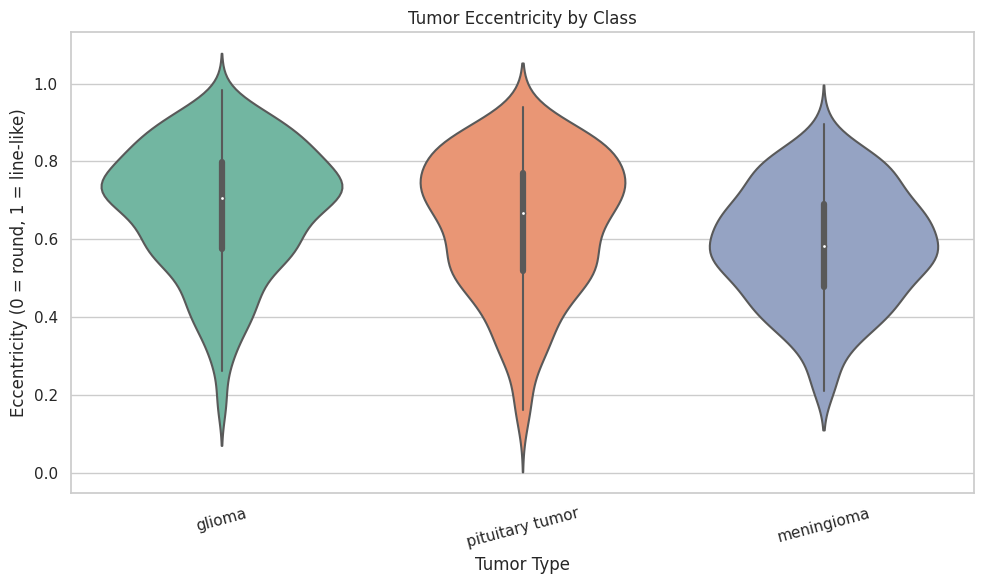

In [23]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=stat_df, x='label_name', y='eccentricity', palette='Set2')
plt.title('Tumor Eccentricity by Class')
plt.ylabel('Eccentricity (0 = round, 1 = line-like)')
plt.xlabel('Tumor Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### IV. Tumor Perimeter Comparison
- Shows how the length of tumor boundary is compaired with others

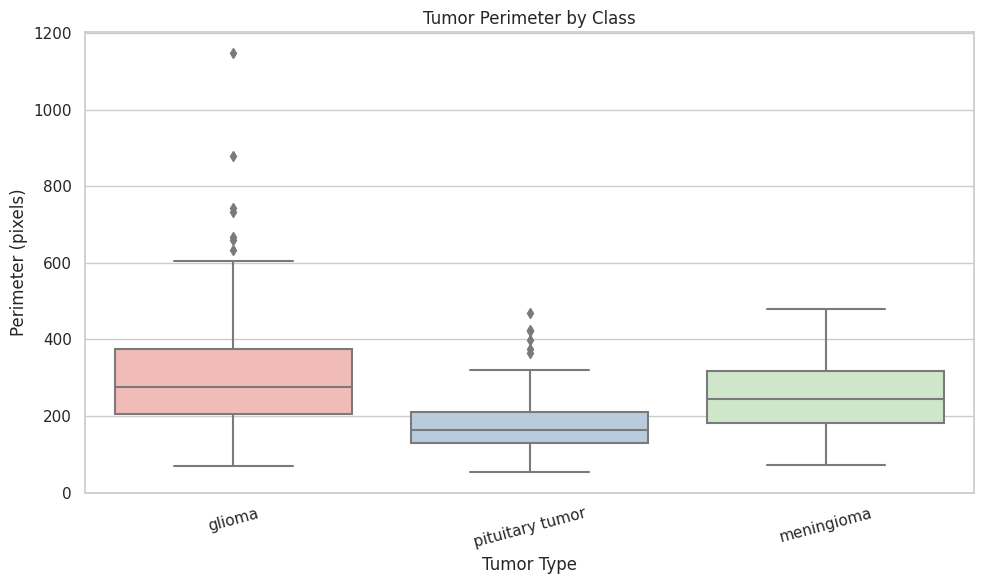

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=stat_df, x='label_name', y='tumor_perimeter', palette='Pastel1')
plt.title('Tumor Perimeter by Class')
plt.ylabel('Perimeter (pixels)')
plt.xlabel('Tumor Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### V. Tumor Aspect Ratio Comparison
- Its Width/Height of bounding box measurement

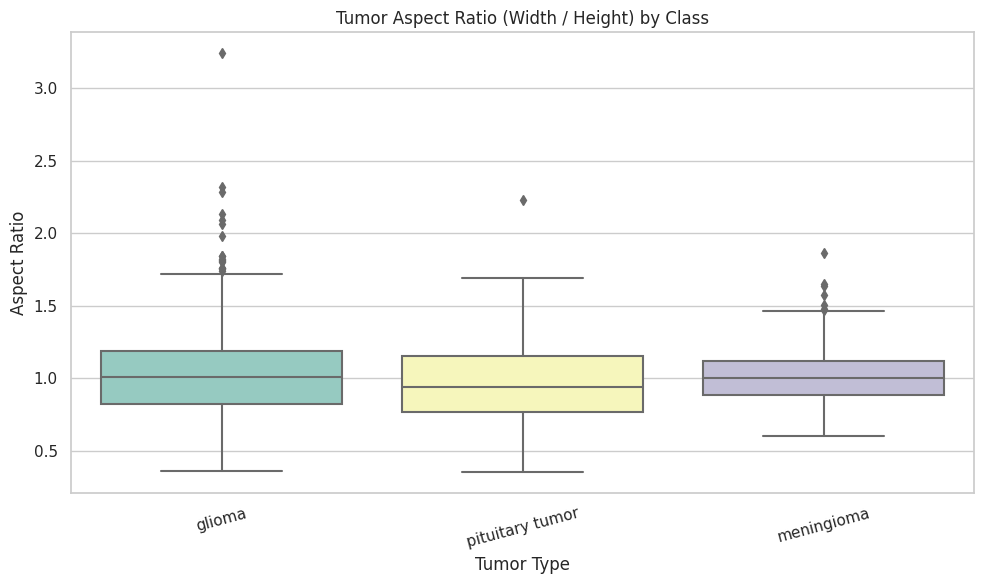

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=stat_df, x='label_name', y='aspect_ratio', palette='Set3')
plt.title('Tumor Aspect Ratio (Width / Height) by Class')
plt.ylabel('Aspect Ratio')
plt.xlabel('Tumor Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### VI. Solidity Comparison (shape fill-ness)
Shows how the Area / Convex Hull Area or how filled the shape is

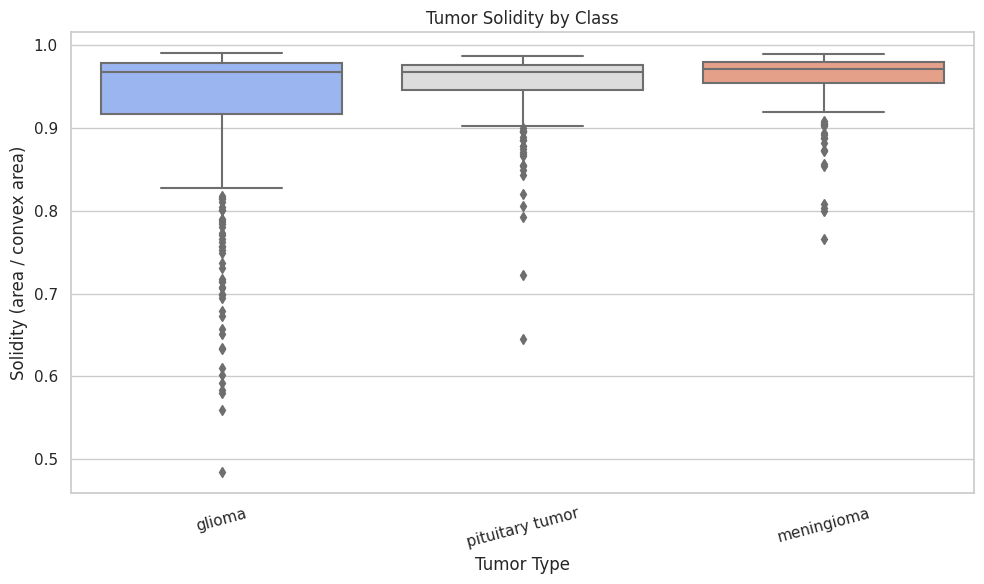

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=stat_df, x='label_name', y='solidity', palette='coolwarm')
plt.title('Tumor Solidity by Class')
plt.ylabel('Solidity (area / convex area)')
plt.xlabel('Tumor Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### VII. Pixel Intensity Histograms by Class


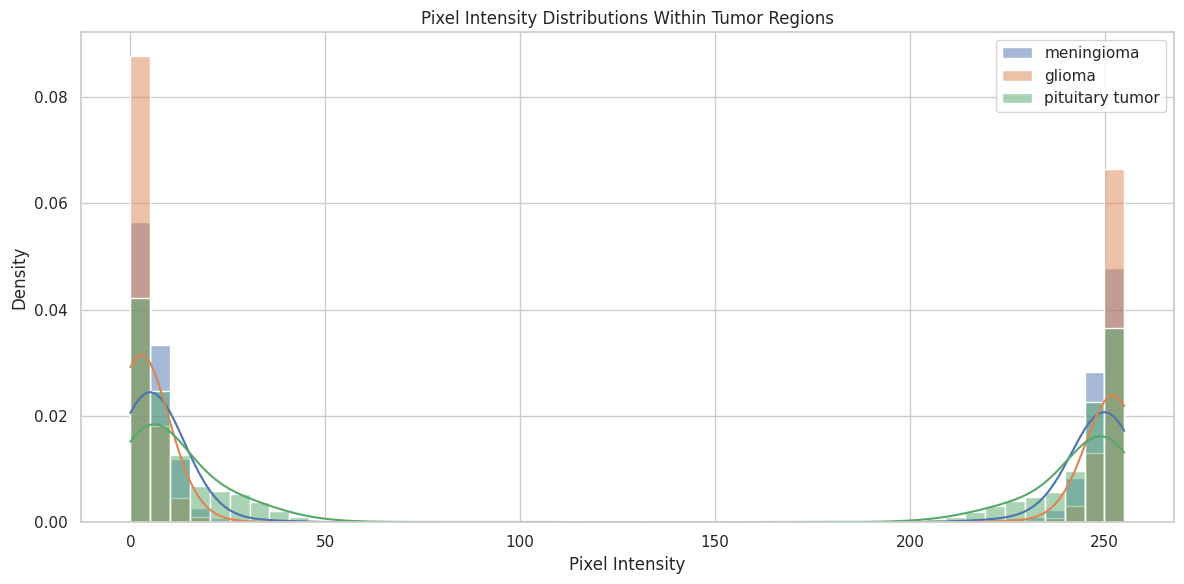

In [27]:
# plot intensity distribution for the masks
plt.figure(figsize=(12, 6))
for label in [1, 2, 3]:
    class_images = sample_df[sample_df.label == label]
    pixels = []
    for _, row in class_images.iterrows():
        img = np.array(Image.open(row["image_path"]))
        mask = np.array(Image.open(row["mask_path"])) > 0
        pixels.extend(img[mask])

    sns.histplot(pixels, label=label_mapping_to_name[label], kde=True, stat='density', bins=50)

plt.title("Pixel Intensity Distributions Within Tumor Regions")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


### VIII. Tumor Location Heatmap
This shows where tumors tend to appear in image space.

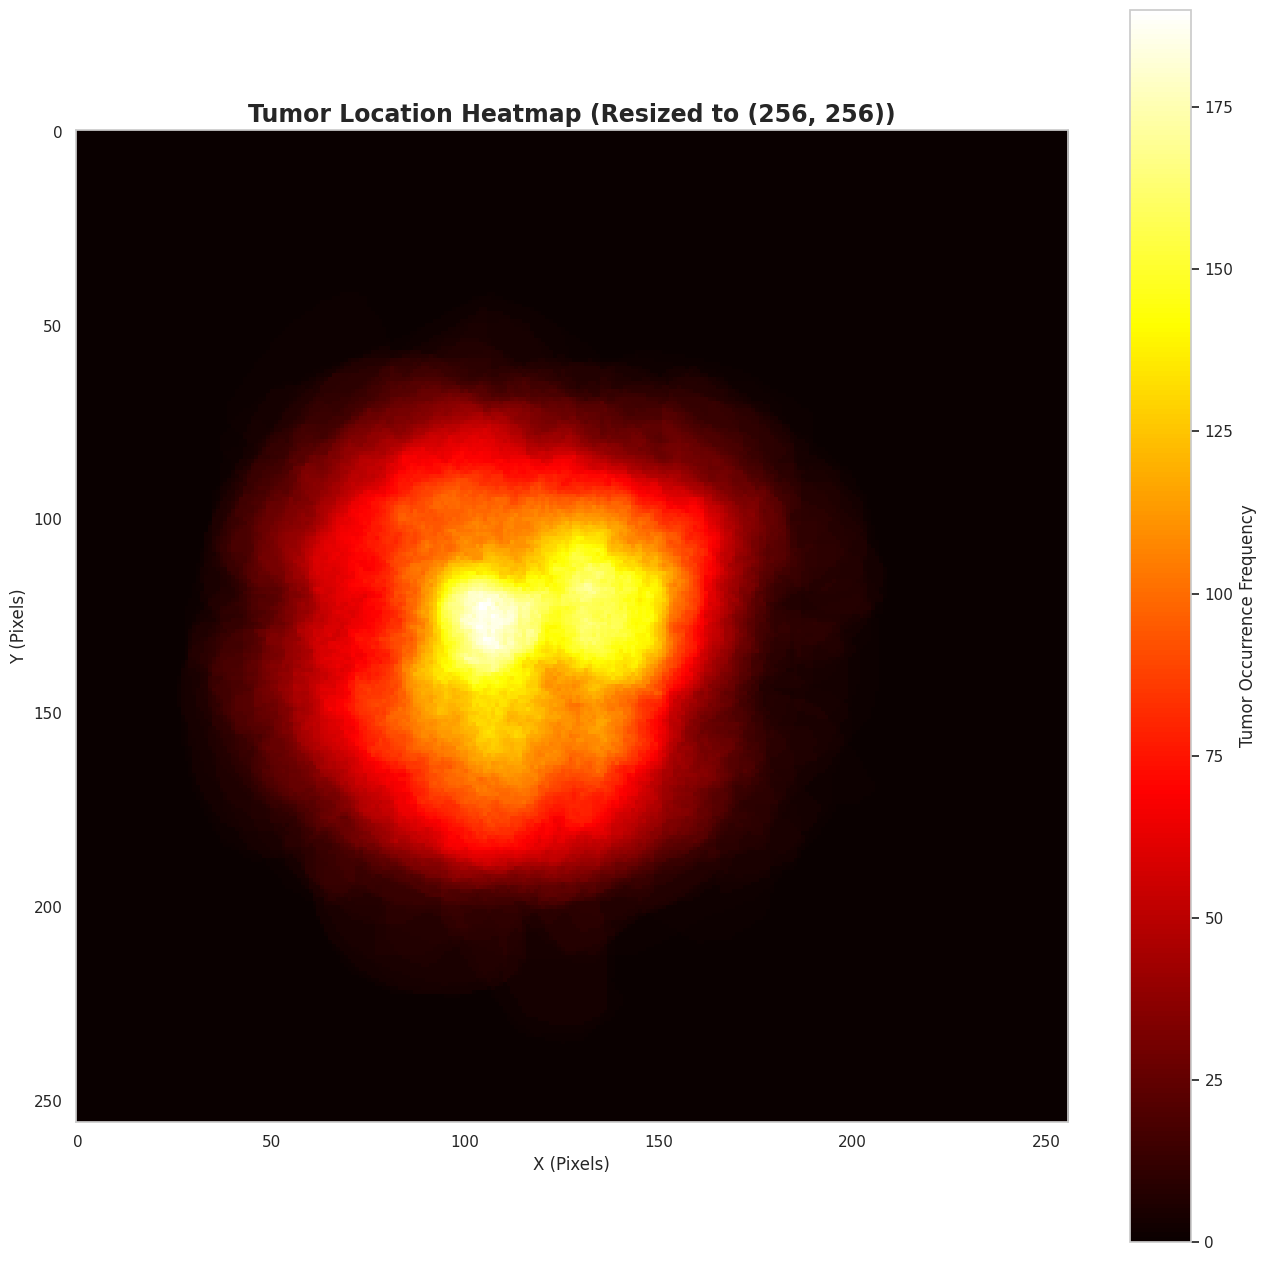

In [28]:
# get a size to resizes our images to
target_size = (256, 256)
heatmap = np.zeros(target_size, dtype=np.float32)
for _, row in sample_df.iterrows():
    mask = Image.open(row['mask_path']).convert('L').resize(target_size)
    mask = np.array(mask) > 0 
    heatmap += mask.astype(np.float32)

plt.figure(figsize=(16, 16))
plt.imshow(heatmap, cmap='hot')
plt.title(f"Tumor Location Heatmap (Resized to {target_size})", fontweight="bold", fontsize=17)
plt.colorbar(label='Tumor Occurrence Frequency')
plt.xlabel("X (Pixels)")
plt.ylabel("Y (Pixels)")
plt.grid(False)
plt.show()


---
#### Data Splitting Methodology
The data is going to be divided into three subsets which does not overlap which are:
- Training subset (60%) - Which will be the main split used for training the model
- validation subset (20%) - For tuning model hyperparameters and overfitting checking. This is used during the training process/validates the model
- Test Set (20%) - For final model testing and evaluations. This is what we will used to get perfomance metrics

The split will be performed in two phases with **stratified sampling** to maintain the **class distributions** (meningioma, glioma, pituitary tumor) across all subsets as folows;
1. **First Split** -  60% of data was allocated to the training set, and the other 40% was kept temporarily separate.
2. **Second Split** - This is a temporary split which is divided equally into the validation and test sets (each 20% of the total data).
This approach ensures the model to be trained and tested on various data and finally tested on **fully unseen** instances, which is critical in measuring real-world generalization.

In [29]:
df.head()

,image_path,mask_path,label,label_name
0,./processed_data/images/827.png,./processed_data/masks/827_mask.png,2,glioma
1,./processed_data/images/1869.png,./processed_data/masks/1869_mask.png,2,glioma
2,./processed_data/images/1864.png,./processed_data/masks/1864_mask.png,2,glioma
3,./processed_data/images/248.png,./processed_data/masks/248_mask.png,1,meningioma
4,./processed_data/images/2869.png,./processed_data/masks/2869_mask.png,2,glioma


In [30]:
# perform the first split 60:40
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df.label,
    random_state=2025
)

# get the 40% split  into 20% val and 20% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df.label,
    random_state=2025
)


print(
    f"""
Train Size {train_df.shape}  --> {len(train_df)/len(df):.4f} 
Test Size {test_df.shape} --> {len(test_df)/len(df):.4f} 
Val Size {val_df.shape} -->  {len(val_df)/len(df):.4f} 
    """
)


Train Size (1838, 4)  --> 0.5999 
Test Size (613, 4) --> 0.2001 
Val Size (613, 4) -->  0.2001 
    
